In [173]:
from utils import MiniWrapper
from itertools import combinations
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import stormpy
import stormpy.core
import stormpy.simulator

import stormpy.shields
import stormpy.logic

import stormpy.examples
import stormpy.examples.files

from PIL import Image, ImageDraw

import re
import numpy as np

import gymnasium as gym

import os

from IPython.display import display
import time
from pathlib import Path

### Load MiniGrid Environment

In [174]:
os.environ['M2P_BINARY'] = '/opt/Minigrid2PRISM/build/main'

# Edit /opt/environments/notebooks/Minigrid/minigrid/envs/Playground.py for custom environment 
env = "MiniGrid-Playground-v0"

# env = "MiniGrid-LavaSlipperyCliff-16x13-Slip10-Time-v0"

# Set n, k
n = 5
k = 1
actions_possible = ['0', '1', '2']

env = gym.make(env, render_mode="rgb_array")
image_env = RGBImgObsWrapper(env, TILE_PIXELS)
env = RGBImgObsWrapper(env, 8)
env = ImgObsWrapper(env)
env = MiniWrapper(env)
Path("test/").mkdir(exist_ok=True)
grid_file = 'test/old_grid.txt'
old_prism = 'test/old_prism.txt'
new_prism = 'test/new_prism.txt'
new_shield = 'test/new_shield.txt'
with open(grid_file, "w") as f:
    f.write(env.printGrid(init=True))
os.system(F"{os.getenv('M2P_BINARY')} -i {grid_file} -o {old_prism}")
onLavaFormula = "formula OnLava = "
colAgentRange = ""
rowAgentRange = ""
with open(old_prism, 'r') as f:
    for line in f:
        if(line.startswith("formula AgentIsOnLava = ")):
            onLavaFormula += line[23:]
        if("colAgent : [" in line):
            colAgentRange = line
        if("rowAgent : [" in line):
            rowAgentRange = line

/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.printGrid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.printGrid` for environment variables or `env.get_wrapper_attr('printGrid')` that will search the reminding wrappers.
  logger.warn(


### Load mdp for Playground

In [175]:
program = stormpy.parse_prism_program(old_prism)
formulas = stormpy.parse_properties_for_prism_program("", program)
options = stormpy.BuilderOptions([p.raw_formula for p in formulas])
options.set_build_state_valuations(True)
options.set_build_choice_labels(True)
options.set_build_all_labels()
old_model = stormpy.build_sparse_model_with_options(program, options)
print(old_model)

-------------------------------------------------------------- 
Model type: 	MDP (sparse)
States: 	100
Transitions: 	279
Choices: 	253
Reward Models:  none
State Labels: 	2 labels
   * deadlock -> 12 item(s)
   * init -> 69 item(s)
Choice Labels: 	6 labels
   * Agent_turn_right -> 88 item(s)
   * Agent_turn_left -> 88 item(s)
   * Agent_move_East -> 16 item(s)
   * Agent_move_South -> 16 item(s)
   * Agent_move_West -> 16 item(s)
   * Agent_move_North -> 17 item(s)
-------------------------------------------------------------- 



### Construct new MDP
The newer MDP contains states with additional information of last seen state, and actions taken after it

This handles the case when we are not able to observe the environment

In [176]:
choice_labeling = old_model.choice_labeling
state_valuations = old_model.state_valuations
mdp = {}
for state in old_model.states:
    state_valuation = state_valuations.get_string(state)
    ints = dict(re.findall(r'([a-zA-Z][_a-zA-Z0-9]+)=(-?[a-zA-Z0-9]+)', state_valuation))
    mdp[str(state)] = ({'colAgent': ints['colAgent'], 
                        'rowAgent': ints['rowAgent'], 
                        'viewAgent': ints['viewAgent'], 
                        'actions': tuple([-1 for _ in range(k)])
                        })
    
    for action_possible in actions_possible:
        mdp[str(state)][action_possible] = []
    for action in state.actions:
        old_action = str(action)
        actions = list(choice_labeling.get_labels_of_choice(old_model.get_choice_index(state, int(str(action)))))
        if(len(actions)==0):
            continue
        if('left' in actions[0]):
            action_name = '0'
        elif('right' in actions[0]):
            action_name = '1'
        elif('move' in actions[0]):
            action_name = '2'
        elif "pickup" in actions[0]:
            action_name = '3'
        elif "drop" in actions[0]:
            action_name = '4'
        elif "toggle" in actions[0]:
            action_name = '5'
        elif "done" in actions[0]:
            action_name = '6'
        else:
            continue

        for transition in action.transitions:
            mdp[str(state)][action_name].append(str(transition.column))
            # intsd = dict(re.findall(r'([a-zA-Z][_a-zA-Z0-9]+)=(-?[a-zA-Z0-9]+)', state_valuations.get_string(int(transition.column))))


next_idx = len(mdp) + 1
mdps = [{} for _ in range(k+1)]
mdps[0] = mdp
combined_mdp = mdps[0]
for i in range(1,k+1):
    mdp_next = {}
    for state in mdps[i-1]:
        state_info = mdps[i-1][state]
        for action in actions_possible:
            if(len(state_info[action])<=0):
                continue
            new_actions = list(state_info['actions'])
            new_actions[i-1] = action
            mdp_next[str(next_idx)] = ({'colAgent': state_info['colAgent'], 
                                    'rowAgent': state_info['rowAgent'], 
                                    'viewAgent': state_info['viewAgent'], 
                                    'actions': tuple(new_actions)
                                    })
            for action_possible in actions_possible:
                mdp_next[str(next_idx)][action_possible] = []
            for next_state in state_info[action]:
                for action_possible in actions_possible:
                    mdp_next[str(next_idx)][action_possible] += (combined_mdp[next_state][action_possible])
            mdps[i-1][state][action].append(str(next_idx))
            next_idx += 1
    mdps[i] = mdp_next
    combined_mdp = combined_mdp | mdps[i]

with open('test/temp.txt', 'w')as f:
    f.write(str(combined_mdp))
    f.write('\n')


### Add history information to states
History means the time (relative to current) when the environment didn't return the state

In [177]:
cross_mdp = {}

def eligible_histories(state):
    actions = state['actions']
    history = []
    cnt = 0
    for i, a in enumerate(actions):
        if(a!=-1):
            history.append(i+1)
        else:
            cnt += 1

    if(cnt==0):
        return [history]
    
    add_histories = []
    for j in range(cnt+1):
        prod = [list(i) + [n+1] * j for i in combinations(range(len(history)+2,n+1),cnt-j)]
        add_histories += prod

    histories = []
    for e in add_histories:
        histories.append(history + list(e))

    return histories

def incr(x):
    return min(x+1, n+1)

def nextObs(hist1):
    hist2 = [0 for _ in range(k)]
    for i in range(k):
        hist2[i] = incr(hist1[i])
    return hist2

def nextNonObs(hist1):
    hist2 = [1 for _ in range(k)]
    if(k==0):
        return []
    if(hist1[k-1]<n):
        return []
    for i in range(1,k):
        hist2[i] = incr(hist1[i-1])
    return hist2

cross_mdp = {}
for state in combined_mdp:
    # for i in range(1,k+1):
    base_state = dict(combined_mdp[state])
    for action_possible in actions_possible:
        base_state.pop(action_possible, None)
    for history in eligible_histories(base_state):
        base_state['history'] = tuple(history)
        cross_mdp[tuple(sorted(base_state.items()))] = {}
        for action_possible in actions_possible:
            cross_mdp[tuple(sorted(base_state.items()))][action_possible] = []


for state in combined_mdp:
    state_info = combined_mdp[state]
    for action in actions_possible:
        for next_state in state_info[action]:
            histories1 = eligible_histories(combined_mdp[state])
            histories2 = eligible_histories(combined_mdp[next_state])
            base_state_1 = dict(combined_mdp[state])
            base_state_2 = dict(combined_mdp[next_state])
            for action_possible in actions_possible:
                base_state_1.pop(action_possible, None)
                base_state_2.pop(action_possible, None)
                
            for hist1 in histories1:
                hist2 = nextObs(hist1)
                if hist2 in histories2:
                    base_state_1['history'] = tuple(hist1)
                    base_state_2['history'] = tuple(hist2)
                    cross_mdp[tuple(sorted(base_state_1.items()))][action].append(tuple(sorted(base_state_2.items())))
                
                hist2 = nextNonObs(hist1)
                if hist2 in histories2:
                    base_state_1['history'] = tuple(hist1)
                    base_state_2['history'] = tuple(hist2)
                    cross_mdp[tuple(sorted(base_state_1.items()))][action].append(tuple(sorted(base_state_2.items())))



### Export new MDP to PRISM format

In [178]:
with open(new_prism, 'w') as f:
    f.write("mdp\n\n")
    f.write(f"{onLavaFormula}\n")
    f.write("init\n")
    f.write("  true\n")
    f.write("endinit\n\n\n")
    f.write("module Agent\n")
    f.write(colAgentRange)
    f.write(rowAgentRange)
    f.write("  viewAgent : [0..3];\n")
    for i in range(1,k+1):
        f.write(f"  action{i} : [-1..{len(actions_possible)-1}];\n")
    for i in range(1,k+1):
        f.write(f"  history{i} : [1..{n+1}];\n")

    for state in cross_mdp:
        state_info = dict(state)
        for (action, action_name) in [('0', 'left'), ('1', 'right'), ('2', 'move')]:
            
            if(len(cross_mdp[state][action])==0):
                continue
            f.write(f"  [{action_name}] colAgent={state_info['colAgent']} & rowAgent={state_info['rowAgent']} & viewAgent={state_info['viewAgent']}")
            for i in range(1,k+1):
                f.write(f" & action{i}={state_info['actions'][i-1]}")
            for i in range(1,k+1):
                f.write(f" & history{i}={state_info['history'][i-1]}")
            f.write(" -> ")
            for (idx, next_state) in enumerate(cross_mdp[state][action]):
                next_state_info = dict(next_state)
                f.write(f"{1/len(cross_mdp[state][action])}: (colAgent'={next_state_info['colAgent']})&(rowAgent'={next_state_info['rowAgent']})&(viewAgent'={next_state_info['viewAgent']})")
                for i in range(1,k+1):
                    f.write(f"&(action{i}'={next_state_info['actions'][i-1]})")
                for i in range(1,k+1):
                    f.write(f"&(history{i}'={next_state_info['history'][i-1]})")
                if(idx != len(cross_mdp[state][action]) - 1):
                    f.write(" + ")
                else:
                    f.write(";\n")

    f.write("endmodule")

### Write to PRISM (Without history information)

In [179]:
with open('test/combined_mdp.prism', 'w') as f:
    f.write("mdp\n\n")
    f.write(f"{onLavaFormula}\n")
    f.write("init\n")
    f.write("  true\n")
    f.write("endinit\n\n\n")
    f.write("module Agent\n")
    f.write(colAgentRange)
    f.write(rowAgentRange)
    f.write("  viewAgent : [0..3];\n")
    for i in range(1,k+1):
        f.write(f"  action{i} : [-1..{len(actions_possible)-1}];\n")

    for state in combined_mdp:
        state_info = combined_mdp[state]
        for (action, action_name) in [('0', 'left'), ('1', 'right'), ('2', 'move')]:
            
            if(len(state_info[action])==0):
                continue
            f.write(f"  [{action_name}] colAgent={state_info['colAgent']} & rowAgent={state_info['rowAgent']} & viewAgent={state_info['viewAgent']}")
            for i in range(1,k+1):
                f.write(f" & action{i}={state_info['actions'][i-1]}")
            f.write(" -> ")
            for (idx, next_state) in enumerate(state_info[action]):
                next_state_info = combined_mdp[next_state]
                f.write(f"{1/len(state_info[action])}: (colAgent'={next_state_info['colAgent']})&(rowAgent'={next_state_info['rowAgent']})&(viewAgent'={next_state_info['viewAgent']})")
                for i in range(1,k+1):
                    f.write(f"&(action{i}'={next_state_info['actions'][i-1]})")
                if(idx != len(state_info[action]) - 1):
                    f.write(" + ")
                else:
                    f.write(";\n")

    f.write("endmodule")

### Load New MDP

In [180]:

formula = 'Pmax=? [G ! OnLava]'
program = stormpy.parse_prism_program(new_prism)

formulas = stormpy.parse_properties_for_prism_program(formula, program)
options = stormpy.BuilderOptions([p.raw_formula for p in formulas])
options.set_build_state_valuations(True)
options.set_build_choice_labels(True)
options.set_build_all_labels()

### Build model for new MDP

In [181]:
model = stormpy.build_sparse_model_with_options(program, options)
print(model)

-------------------------------------------------------------- 
Model type: 	MDP (sparse)
States: 	1834
Transitions: 	3713
Choices: 	3000
Reward Models:  none
State Labels: 	3 labels
   * deadlock -> 1162 item(s)
   * init -> 1561 item(s)
   * !(((((colAgent = 4) & (rowAgent = 2)) | ((colAgent = 2) & (rowAgent = 3))) | ((colAgent = 3) & (rowAgent = 4)))) -> 1546 item(s)
Choice Labels: 	3 labels
   * left -> 672 item(s)
   * move -> 494 item(s)
   * right -> 672 item(s)
-------------------------------------------------------------- 



### Calculate shield for new MDP

In [182]:
shield_comparison = stormpy.logic.ShieldComparison.ABSOLUTE
shield_expression = stormpy.logic.ShieldExpression(stormpy.logic.ShieldingType.PRE_SAFETY, shield_comparison,  1.0)

result = stormpy.model_checking(model, formulas[0], extract_scheduler=True, shield_expression=shield_expression)
assert result.has_shield

### Export new shield

In [183]:
shield = result.shield
action_dictionary = dict()
shield_scheduler = shield.construct()
state_valuations = model.state_valuations
choice_labeling = model.choice_labeling
stormpy.shields.export_shield(model, shield, new_shield)

 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 101
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 106
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 122
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 133
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 138
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 154
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 197
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 213
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 214
 WARN (PreShield.cpp:50): No shielding action possible 

### Get action mask using Shield

In [184]:
def get_allowed_actions_mask(actions):
    action_mask = [0.0] * 7
    actions_labels = [label for labels in actions for label in list(labels)]
    for action_label in actions_labels:
        if "move" in action_label:
            action_mask[2] = 1.0
        elif "left" in action_label:
            action_mask[0] = 1.0
        elif "right" in action_label:
            action_mask[1] = 1.0
        elif "pickup" in action_label:
            action_mask[3] = 1.0
        elif "drop" in action_label:
            action_mask[4] = 1.0
        elif "toggle" in action_label:
            action_mask[5] = 1.0
        elif "done" in action_label:
            action_mask[6] = 1.0
    return action_mask

for stateID in model.states:
    choice = shield_scheduler.get_choice(stateID)
    choices = choice.choice_map

    state_valuation = state_valuations.get_string(stateID)
    ints = dict(re.findall(r'([a-zA-Z][_a-zA-Z0-9]+)=(-?[a-zA-Z0-9]+)', state_valuation))
    booleans = re.findall(r'(\!?)([a-zA-Z][_a-zA-Z0-9]+)[\s\t]+', state_valuation)
    booleans = {b[1]: False if b[0] == "!" else True for b in booleans}
    
    state = tuple(sorted(ints.items()))
    action_dictionary[state] = get_allowed_actions_mask([choice_labeling.get_labels_of_choice(model.get_choice_index(stateID, choice[1])) for choice in choices])

### Visualise the Shield
For (k=0) OR (k=1 AND n>=4) OR (k=2 AND n>=5)

k=1; n>=4
When there are no non-observed states in the last n states:
Which means next state can be unobserved


/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will searc

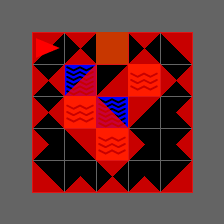

The previous state wasn't observed
i.e. Next state will definitely be observed
Next to next state will also be observed


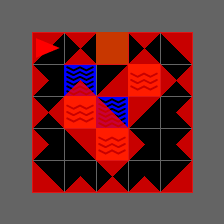

When the last non-observed state occured n-1 steps before
i.e. The next state would definitely be observed, but can't say for the next to next one


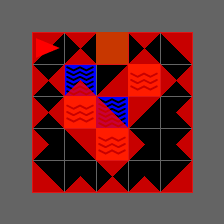

In [185]:
def triangle_for_overlay(x,y, dir, tile_size):
    offset = tile_size/2
    if dir == 0: return [((x+1)*tile_size,y*tile_size), ((x+1)*tile_size,(y+1)*tile_size), ((x+1)*tile_size-offset, y*tile_size+tile_size/2)]
    if dir == 1: return [(x*tile_size,(y+1)*tile_size), ((x+1)*tile_size,(y+1)*tile_size), (x*tile_size+tile_size/2, (y+1)*tile_size-offset)]
    if dir == 2: return [(x*tile_size,y*tile_size), (x*tile_size,(y+1)*tile_size), (x*tile_size+offset, y*tile_size+tile_size/2)]
    if dir == 3: return [(x*tile_size,y*tile_size), ((x+1)*tile_size,y*tile_size), (x*tile_size+tile_size/2, y*tile_size+offset)]
        
def create_shield_overlay_image(env, shield, history):
    env.reset()
    img = Image.fromarray(env.render()).convert("RGBA")
    ts = env.tile_size
    overlay = Image.new("RGBA", img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    red = (255,0,0,200)
    for x in range(0, env.width):
        for y in range(0, env.height):
            for dir in range(0,4):
                key = {'colAgent': str(x+1), 'rowAgent': str(y+1), 'viewAgent': str(dir)}
                for i in range(1,k+1):
                    key[f"action{i}"] = '-1'
                for i in range(1,k+1):
                    key[f"history{i}"] = str(history[i-1])
                key = tuple(sorted(key.items()))
                # print(key)
                try:
                    if shield[key][2] <= 0.0:
                        draw.polygon(triangle_for_overlay(x+1,y+1,dir,ts), fill=red)
                except KeyError: pass
    img = Image.alpha_composite(img, overlay)
    img.show()
    
if(k==0):
    print("k=0; default shield; Observation guaranteed at all steps")
    create_shield_overlay_image(image_env, action_dictionary, [])

if(k==1 and n>=4):
    history = []
    print("k=1; n>=4")
    print("When there are no non-observed states in the last n states:")
    print("Which means next state can be unobserved")
    for i in range(1,k+1):
        history.append(str(n+1))
    create_shield_overlay_image(image_env, action_dictionary, history)

    print("The previous state wasn't observed")
    print("i.e. Next state will definitely be observed")
    print("Next to next state will also be observed")
    history = ['2']
    create_shield_overlay_image(image_env, action_dictionary, history)

    print("When the last non-observed state occured n-1 steps before")
    print("i.e. The next state would definitely be observed, but can't say for the next to next one")
    history = [str(n-1)]
    create_shield_overlay_image(image_env, action_dictionary, history)

if(k==2 and n>=5):
    history = []
    print("k=2; n>=5")
    print("When there are no non-observed states in the last n states:")
    print("Which means next state can be unobserved")
    for i in range(1,k+1):
        history.append(str(n+1))
    create_shield_overlay_image(image_env, action_dictionary, history)

    print("The previous two states wasn't observed")
    print("i.e. Next state will definitely be observed")
    print("Next to next state will also be observed")
    history = ['2', '3']
    create_shield_overlay_image(image_env, action_dictionary, history)

    print("The last two non-observed states occured n-2 and n-1 steps before")
    print("i.e. The next state would definitely be observed, but can't say for the next to next one")
    history = [str(n-2), str(n-1)]
    create_shield_overlay_image(image_env, action_dictionary, history)

### Simulation

/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_dir to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_dir` for environment variables or `env.get_wrapper_attr('agent_dir')` that will search the reminding wrappers.
  logger.warn(


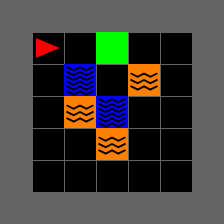

State: {'colAgent': '1', 'rowAgent': '1', 'viewAgent': '0', 'action1': '-1', 'history1': '6'}
Allowed Actions: [0, 1, 2]
Action Taken: 1
Observed:


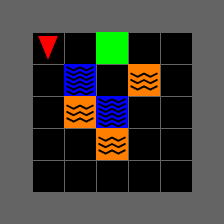

State: {'colAgent': '1', 'rowAgent': '1', 'viewAgent': '1', 'action1': '-1', 'history1': '6'}
Allowed Actions: [0, 1, 2]
Action Taken: 2
Observed:


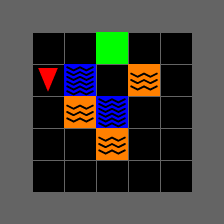

State: {'colAgent': '1', 'rowAgent': '2', 'viewAgent': '1', 'action1': '-1', 'history1': '6'}
Allowed Actions: [0, 1, 2]
Action Taken: 0
Observed:


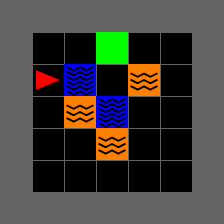

State: {'colAgent': '1', 'rowAgent': '2', 'viewAgent': '0', 'action1': '-1', 'history1': '6'}
Allowed Actions: [0, 1]
Action Taken: 2
Observed:


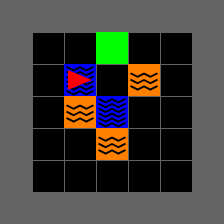

State: {'colAgent': '2', 'rowAgent': '2', 'viewAgent': '0', 'action1': '-1', 'history1': '6'}
Allowed Actions: []
No possible action!
Action Taken: 2
Not Observed:


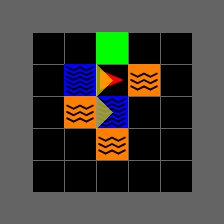

State: {'colAgent': '2', 'rowAgent': '2', 'viewAgent': '0', 'action1': '2', 'history1': '1'}
Allowed Actions: []
No possible action!
Action Taken: 2
Observed:


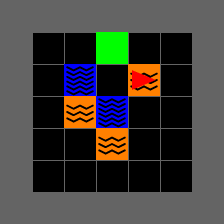

State: {'colAgent': '4', 'rowAgent': '2', 'viewAgent': '0', 'action1': '-1', 'history1': '2'}
Allowed Actions: []
No possible action!
Action Taken: 


ValueError: invalid literal for int() with base 10: ''

In [186]:
# a = observed
# b = unobserved
# observe_sequence to decide if states are unobserved or observed
# observe_sequence = "abbaa" means first state seen, next two not seen, and then next two seen
# Default sequences for some cases are provided
# The sequnce should obey the (N, k) condition though, otherwise the code may throw an error

if(k==0):
    observe_sequence = "aaaaaaaaaaaaaaaaaaaaa"
elif(k==1 and n<=5):
    observe_sequence = "aaaabaaaaaabaaaabaaaa"
elif(k==2 and n<=5):
    observe_sequence = "aaabbaaabbaaaababaaaa"
else:
    observe_sequence = ""

env.reset()
pos = tuple(env.agent_pos)
direc = env.agent_dir
state = {'colAgent': str(pos[0]), 'rowAgent': str(pos[1]), 'viewAgent': str(direc)}
for i in range(1,k+1):
    state[f"action{i}"] = '-1'
for i in range(1,k+1):
    state[f"history{i}"] = str(n+1)

img = Image.fromarray(image_env.render()).convert("RGBA")
img.show()

for e in observe_sequence:
    action_values = action_dictionary[tuple(sorted(state.items()))]
    allowed_actions = []
    for idx, value in enumerate(action_values):
        if(value>0.9):
            allowed_actions.append(idx)
            
    print("State:", state) 
    print("Allowed Actions:", allowed_actions, flush=True)

    
    if(len(allowed_actions)==0):
        print("No possible action!", flush=True)

    next_action = input("Which action?")

    print(f"Action Taken: {next_action}")
    env.step(int(next_action))

    pos = tuple(env.agent_pos)
    direc = env.agent_dir

    if(e=="a"):
        state['colAgent'] = str(pos[0])
        state['rowAgent'] = str(pos[1])
        state['viewAgent'] = str(direc)
        for i in range(1,k+1):
            state[f"action{i}"] = '-1'
            
        old_history = []
        for i in range(1,k+1):
            old_history.append(int(state[f"history{i}"]))
            
        new_history = nextObs(old_history)
        for i in range(1,k+1):
            state[f"history{i}"] = str(new_history[i-1])
            
        print("Observed:")
        img = Image.fromarray(image_env.render()).convert("RGBA")
        # img.show()
        
    elif(e=="b"):
        old_state = {}
        old_state['colAgent'] = state['colAgent']
        old_state['rowAgent'] = state['rowAgent']
        old_state['viewAgent'] = state['viewAgent']
        old_state['actions'] = []
        for i in range(1,k+1):
            if int(state[f"action{i}"]) == -1:
                old_state['actions'].append(int(state[f"action{i}"]))
            else:
                old_state['actions'].append(str(state[f"action{i}"]))
        old_state['actions'] = tuple(old_state['actions'])
        old_state['history'] = []
        for i in range(1,k+1):
            old_state['history'].append(int(state[f"history{i}"]))
        old_state['history'] = tuple(old_state['history'])
        # print(state, old_state)

        new_states = []
        for next_state in cross_mdp[tuple(sorted(old_state.items()))][str(next_action)]:
            next_state_dict = dict(next_state)
            if(nextObs(list(old_state['history'])) != list(next_state_dict['history'])):
                continue
            new_states.append((int(next_state_dict['colAgent']), int(next_state_dict['rowAgent']), int(next_state_dict['viewAgent']),))
        
        updated = False
        for i in range(1,k+1):
            if state[f"action{i}"]=='-1' and not updated:
                state[f"action{i}"] = str(next_action)
                updated=True

        old_history = []
        for i in range(1,k+1):
            old_history.append(int(state[f"history{i}"]))

        new_history = nextNonObs(old_history)
        for i in range(1,k+1):
            state[f"history{i}"] = str(new_history[i-1])

        print("Not Observed:")
        img = Image.fromarray(image_env.render()).convert("RGBA")
        ts = image_env.tile_size
        overlay = Image.new("RGBA", img.size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(overlay)
        yellow = (255,255,0,150)

        for new_state in new_states:
            draw.polygon(triangle_for_overlay(new_state[0],new_state[1],(new_state[2]+2)%4,ts), fill=yellow)

        img = Image.alpha_composite(img, overlay)

    display(img)
    time.sleep(1)